# Imports

In [7]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import exoplanet as xo
import astropy.units as u
from astropy.timeseries import LombScargle
import lightkurve as lk
from astropy.io import fits
from uncertainties import ufloat
from uncertainties.umath import *
from scipy import constants

import pymc3 as pm
import aesara_theano_fallback.tensor as tt
import pymc3_ext as pmx

import arviz as az

In [3]:
%matplotlib inline

In [4]:
mpl.rcParams["figure.figsize"] = (6, 4)
# mpl.rcParams["figure.dpi"] = 300
mpl.rcParams['font.size'] = 12
mpl.rcParams['axes.linewidth'] = 0.8
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['xtick.direction'] = 'inout'
mpl.rcParams['ytick.direction'] = 'inout'
mpl.rcParams['xtick.top'] = True
mpl.rcParams['ytick.right'] = True

# System parameters

In [39]:

# from exofop: https://exofop.ipac.caltech.edu/tess/target.php?id=149788158
epoch_tess = ufloat(2459245.51846, 0.0032401)
epoch_tess2 = ufloat(2458518.087839, 0.0015)

t0s = [59247.39590, epoch_tess.n-2400000]
t0_errs = [1.62543, epoch_tess.s]

period_tess = ufloat(4.7244442, 0.0000431)
period_tess2 = ufloat(0.75, 0.000013)
# periods = [29.609749, period_tess.n] # 2 planets version 
# period_errs = [0.5, period_tess.s]

periods = [29.609749, period_tess.n, ] # 2 planets tess version
period_errs = [0.5, period_tess.s]

depth_tess = ufloat(3470.6759301685, 277.00897) # ppm
duration_tess = ufloat(0.999, 0.373)  # hours
radius_tess = ufloat(1.97562, 0.283431) # R_earth
insolation_tess = 6.29202 # S_earth

stteff_tess = ufloat(3653, 157)
strad_tess = ufloat(0.497204, 0.0147744)
stmass_tess = ufloat(0.495286, 0.0202891)

In [40]:
lk.search_lightcurve('TIC 149788158')

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 08,2019,SPOC,120,149788158,0.0
1,TESS Sector 08,2019,TESS-SPOC,1800,149788158,0.0
2,TESS Sector 08,2019,QLP,1800,149788158,0.0
3,TESS Sector 08,2019,GSFC-ELEANOR-LITE,1800,149788158,0.0
4,TESS Sector 34,2021,SPOC,120,149788158,0.0
5,TESS Sector 34,2021,TESS-SPOC,600,149788158,0.0
6,TESS Sector 34,2021,QLP,600,149788158,0.0
7,TESS Sector 61,2023,SPOC,120,149788158,0.0
8,TESS Sector 61,2023,TESS-SPOC,200,149788158,0.0


In [41]:
sr = lk.search_lightcurve('TIC 149788158', author='SPOC', exptime=120)
sr.table["dataURL"] = sr.table["dataURI"]  # workaround MAST issue
lcc = sr.download_all(flux_column="pdcsap_flux")
lc = lcc.stitch().remove_nans().normalize().remove_outliers()

time = lc.time.value
flux = lc.flux

with fits.open(lcc[0].filename) as hdu:
    hdr = hdu[1].header

texp = hdr["FRAMETIM"] * hdr["NUM_FRM"]
texp /= 60.0 * 60.0 * 24.0

ref_time = 0.5 * (np.min(time) + np.max(time))
x_ = np.ascontiguousarray(time - ref_time, dtype=np.float64)
y_ = np.ascontiguousarray(1e3 * (flux - 1.0), dtype=np.float64) # Here we convert flux to ppt
yerr_ = np.ascontiguousarray(1e3 * lc.flux_err, dtype=np.float64) 

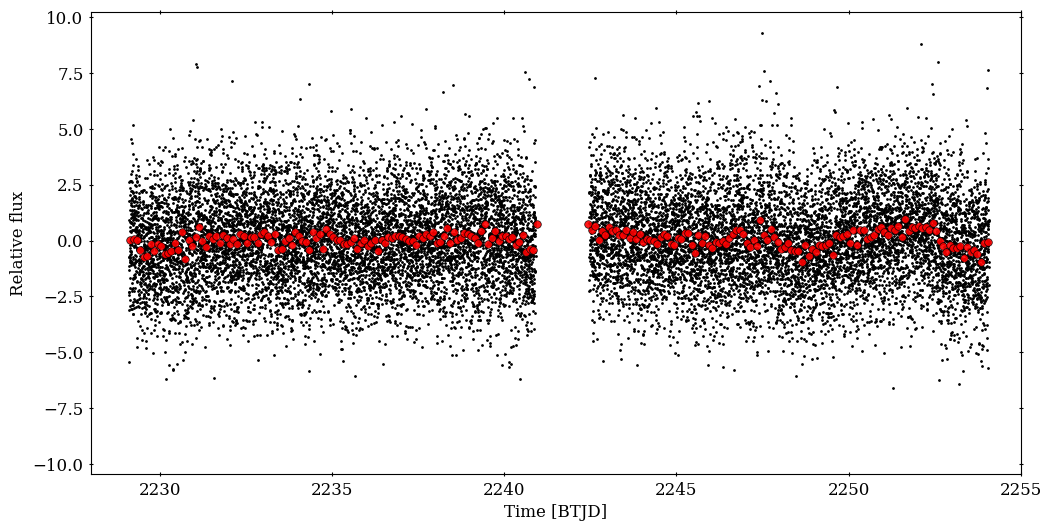

In [42]:
plt.figure(figsize=(12, 6))
plt.plot(time, y_, "o", color='k', markersize=1)
lcc = lk.LightCurve(time=time, flux=y_)
lcc_binned = lcc.bin(time_bin_size=0.1, time_bin_start=lcc.time.value.min(), time_bin_end=lcc.time.value.max())
plt.scatter(lcc_binned['time'].value, lcc_binned['flux'].value, marker='o', s=30,  edgecolors='k', 
                linewidths=0.5, c='r', alpha=0.9, zorder=12)
plt.xlim(2228,2255)
plt.xlabel("Time [BTJD]")
plt.ylabel("Relative flux")
#plt.savefig('tess_sector.png', dpi=300, facecolor='w', bbox_inches='tight')
plt.show()

(2228.0, 2255.0)

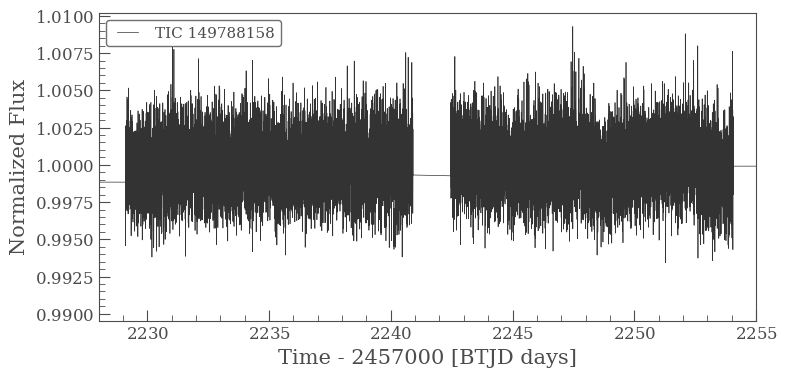

In [43]:
lc.plot()
plt.xlim(2228, 2255)

(-7.199999999999999, 7.199999999999999)

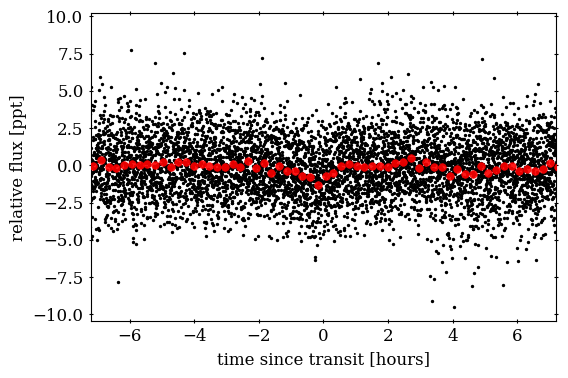

In [44]:
t0_tess = epoch_tess.n-2457000-ref_time
x_fold2 =  (x_ - t0_tess + 0.5 * period_tess.n) % period_tess.n - 0.5 * period_tess.n

x = x_
y = y_
yerr = yerr_
x_fold = x_fold2

plt.scatter(x_fold*24, y, c='k', s=2)
lcc = lk.LightCurve(time=x_fold, flux=y, flux_err=yerr)
lcc_binned = lcc.bin(time_bin_size=0.01, time_bin_start=lcc.time.value.min(), time_bin_end=lcc.time.value.max())
plt.scatter(lcc_binned['time'].value*24, lcc_binned['flux'].value, marker='o', s=30,  edgecolors='r', 
                linewidths=0.5, c='r', alpha=0.9, zorder=12)
plt.xlabel("time since transit [hours]")
plt.ylabel("relative flux [ppt]")
plt.xlim(-0.3*24, 0.3*24)
#plt.savefig('tess_sector_fold.png', dpi=300, facecolor='w', bbox_inches='tight')

# RV reading

In [6]:
lbl_gl846 = pd.read_table('./lbl_toi727_gl846/lbl_TOI727_GL846.rdb', sep=None, engine='python', header=0)
lbl_toi727 = pd.read_table('./lbl_toi727_toi727/lbl_TOI727_TOI727.rdb', sep=None, engine='python', header=0)

lbl2_gl699_car = pd.read_table('./lbl2_carmona/lbl2_TOI727_GL699.rdb', sep=None, engine='python', header=0)
lbl2_gl699_car_vtot10 = pd.read_table('./lbl2_carmona/lbl2_TOI727_GL699_Vtot10corr.rdb', sep='\s+', engine='python', header=0)

lbl2_gl905_car = pd.read_table('./lbl2_carmona/lbl2_TOI727_GL905.rdb', sep=None, engine='python', header=0)
lbl2_gl905_car_vtot10 = pd.read_table('./lbl2_carmona/lbl2_TOI727_GL905_Vtot10corr.rdb', sep='\s+', engine='python', header=0)

lbl2_toi727_car = pd.read_table('./lbl2_carmona/lbl2_TOI727_TOI727.rdb', sep=None, engine='python', header=0)

#names = ['lbl_gl846', 'lbl_toi727']
#names = ['lbl2_gl699_car', 'lbl2_gl905_car', 'lbl2_toi727_car']
names = ['lbl2_gl699_car_vtot10', 'lbl2_gl905_car_vtot10']
#names = ['lbl2_gl699_car_vtot10']

star_name = 'toi727'

In [7]:
print(len(lbl_gl846), len(lbl_toi727), len(lbl2_gl699_car), len(lbl2_gl905_car), len(lbl2_toi727_car), len(lbl2_gl699_car_vtot10), len(lbl2_gl905_car_vtot10))

134 134 38 38 38 35 35


In [8]:
#datasets = list([lbl_gl846, lbl_toi727])
#datasets = list([lbl2_gl699_car, lbl2_gl905_car, lbl2_toi727_car])
datasets = list([lbl2_gl699_car_vtot10, lbl2_gl905_car_vtot10]) 
#datasets = list([lbl2_gl699_car_vtot10])

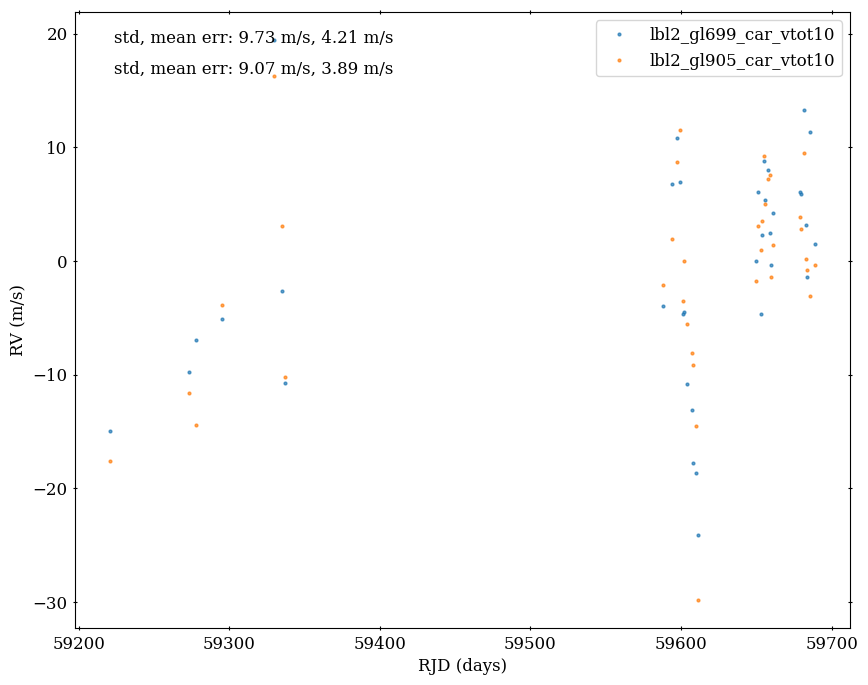

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
for i, data in enumerate(datasets):
    ax.plot(data['rjd'], data['vrad']-np.median(data['vrad']), 'o', ms=2, label=names[i], alpha=0.7)
    ax.set_ylabel('RV (m/s)')
    ax.set_xlabel('RJD (days)')
    ax.text(0.05, 0.95-i*0.05, 'std, mean err: '+str(round(np.std(data['vrad']), 2))+' m/s, '+str(round(np.mean(data['svrad']),2))+' m/s', transform=ax.transAxes)
ax.legend(loc='upper right')
#plt.savefig('rvs_'+star_name+'.png', dpi=300, facecolor='w')
plt.show()
plt.show()

## outliers?

In [10]:
for i in range(len(datasets)):
    print(datasets[i].shape)

(35, 3)
(35, 3)


In [11]:
outliers = []
for k, data in enumerate(datasets):
    sigmas = 3
    datasets[k] = data[np.abs(data['vrad'] - data['vrad'].mean()) <= (sigmas * data['vrad'].std())].reset_index(drop=True)
    a = np.abs(data['vrad'] - data['vrad'].mean()) <= (3 * data['vrad'].std())
    outliers.append(np.size(a) - np.count_nonzero(a))
print(outliers)

[0, 1]


In [12]:
# substract the systemic velocity 
for i in datasets:
    i['vrad'] = i['vrad'].apply(lambda x: x - i['vrad'].median())

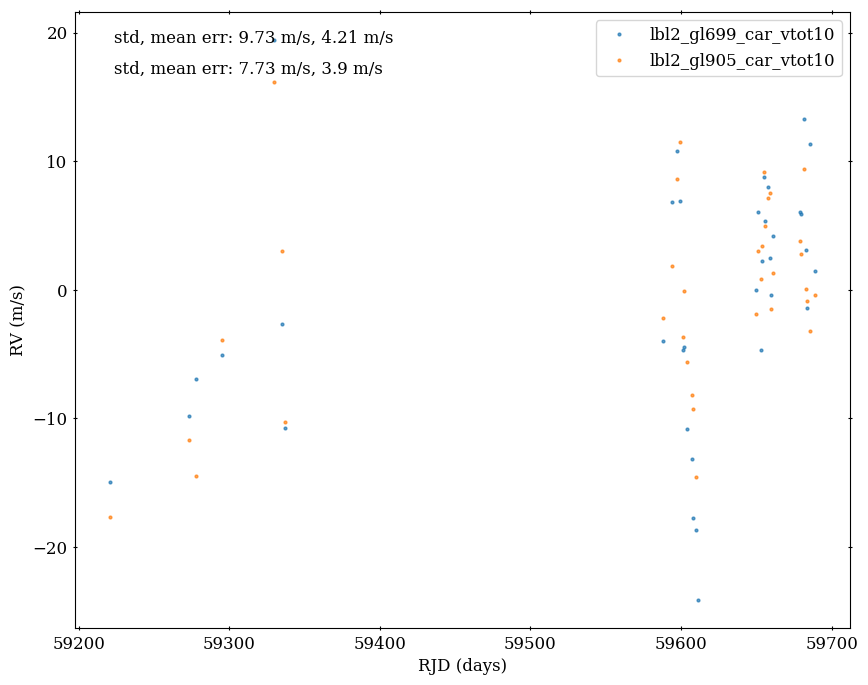

In [13]:
# replot without outliers
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
for i, data in enumerate(datasets):
    ax.plot(data['rjd'], data['vrad']-np.median(data['vrad']), 'o', ms=2, label=names[i], alpha=0.7)
    ax.set_ylabel('RV (m/s)')
    ax.set_xlabel('RJD (days)')
    ax.text(0.05, 0.95-i*0.05, 'std, mean err: '+str(round(np.std(data['vrad']), 2))+' m/s, '+str(round(np.mean(data['svrad']),2))+' m/s', transform=ax.transAxes)
ax.legend(loc='upper right')
plt.show()

# GLS

In [14]:
ls = dict()
frequency = dict()
power = dict()
faps = dict()

for k, data in enumerate(datasets):
    ls[k] = LombScargle(data['rjd'], data['vrad'], data['svrad'])
    frequency[k], power[k] = ls[k].autopower(minimum_frequency=0.005, maximum_frequency=2, samples_per_peak=15)
    probabilities = [0.01]
    faps[k] = ls[k].false_alarm_level(probabilities)

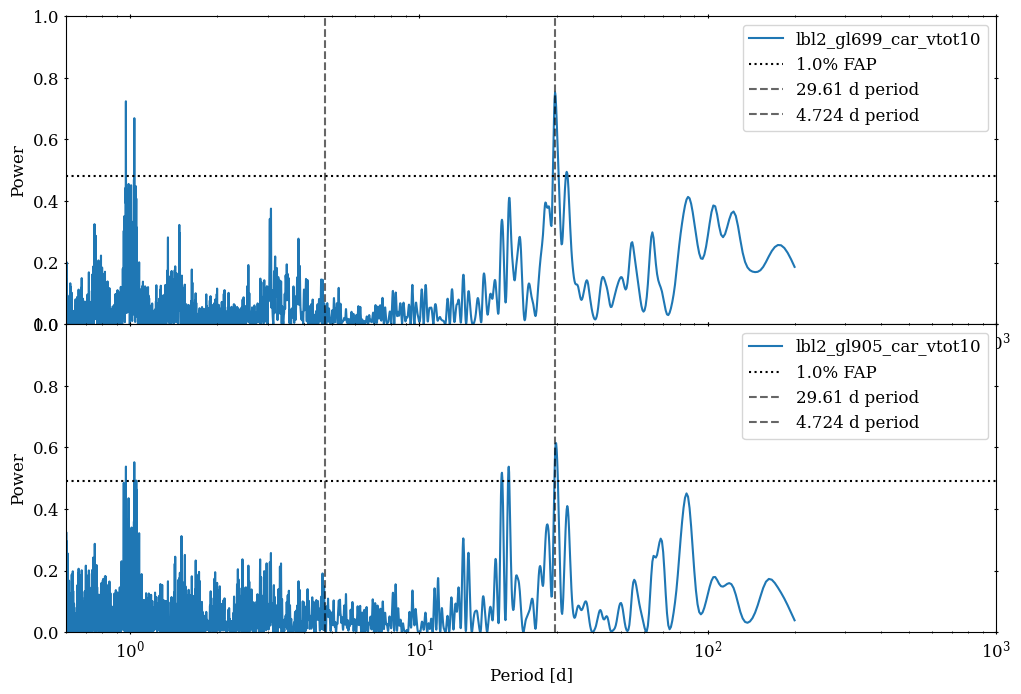

In [15]:
fig, axes = plt.subplots(len(datasets),1, sharex=False, figsize=(12, 4*len(datasets)))
fig.subplots_adjust(hspace=0.0, wspace=0.0)

for i in range(len(datasets)):
    axes[i].plot(1/frequency[i], power[i], label=names[i])
    axes[i].axhline(faps[i], ls=':', color='black', label='{}% FAP'.format(probabilities[0]*100))
    axes[i].set_xscale('log')
    axes[i].set_xlim(0.6, 1000)
    axes[i].set_ylim(0, 1.0)
    axes[i].set_ylabel('Power')
    axes[i].set_xlabel('Period [d]')
    axes[i].axvline(periods[0], ls='--', color='black', alpha=0.6, label='{} d period'.format(round(periods[0], 3)))
    axes[i].axvline(periods[1], ls='--', color='black', alpha=0.6, label='{} d period'.format(round(periods[1], 3)))
    axes[i].legend(loc='upper right')
    axes[i].set_ylim(0, 1)

# RV fit 

In [16]:
x_ref = dict()
maxrv = dict()
Kest = dict()
Kest2 = dict()

for k, data in enumerate(datasets):
    x_ref[k] = 0.5 * (data['rjd'].min() + data['rjd'].max())
    maxrv[k] = np.std(data['vrad'])*3
    #Ks = xo.estimate_semi_amplitude(period_tess.n, data['rjd'], data['vrad'], data['svrad'], t0s=epoch_tess.n-2400000)
    Kest[k] = xo.estimate_semi_amplitude(period_tess.n, data['rjd'], data['vrad'], data['svrad'], t0s=epoch_tess.n-2400000)
    Kest2[k] = xo.estimate_semi_amplitude(29.8, data['rjd'], data['vrad'], data['svrad'])
    print(Kest[k], "m/s 1")
    print(Kest2[k], "m/s 2")


[1.71734231] m/s 1
[12.64509641] m/s 2
[0.15617682] m/s 1
[9.96683594] m/s 2


In [17]:
# Ks_ = [Kest2[0], Kest1[0]]
# Ks_err = [Kest2[0]/2, Kest1[0]/2]

Ks_ = [12.6, 1.7] 
Ks_err = [3, 1.5]

In [18]:
np.median(data['svrad'])

3.6592675163533412

In [19]:
# Make a fine grid that spans the observation window for plotting purposes
model = dict()
t = dict()

for k, data in enumerate(datasets):
    t[k] = np.linspace(data['rjd'].min() - 5, data['rjd'].max() + 5, 3000)

    with pm.Model() as model[k]:
        t0 = pm.Normal("t0", mu=np.array(t0s), sd=np.array(t0_errs), shape=2)
        logP = pm.Normal("logP", mu=np.log(periods), sd=np.array(period_errs) / np.array(periods), shape=2, testval=np.log(periods),)

        P = pm.Deterministic("P", tt.exp(logP))
        # K = pm.Uniform("K", lower=0, upper=maxrv[k])

        # Wide log-normal prior for semi-amplitude
        #logK = pm.Normal("logK", mu=np.log(maxrv[k]), sd=2.0, shape=2)
        #K = pm.Uniform("K", lower=0, upper=maxrv[k], shape=2)
        logK = pm.Normal("logK", mu=np.log(Ks_), sd=2.0, shape=2, testval=np.log(Ks_))
        K = pm.Deterministic("K", tt.exp(logK))

        logs = pm.Normal("logs", mu=np.log(np.median(data['svrad'])/2), sd=1)
        trend = pm.Normal("trend", mu=0, sd=10.0**-np.arange(3)[::-1], shape=3)  # [2,1,0]

        BoundedNormal = pm.Bound(pm.Normal, lower=0, upper=1)
        mstar = BoundedNormal("mstar", mu=stmass_tess.n, sd=stmass_tess.s)
        rstar = BoundedNormal("rstar", mu=strad_tess.n, sd=strad_tess.s)

        orbit = xo.orbits.KeplerianOrbit(period=P, 
                                        t0=t0, 
                                        r_star=rstar, 
                                        m_star=mstar)

        # derive mass and semi-major axis
        m_pl = pm.Deterministic('m_pl', K*(P*u.day.to(u.second)*(mstar*u.M_sun.to(u.kg))**2/(2*np.pi*constants.G))**(1/3))
        a = pm.Deterministic('a', ((P*u.day.to(u.second))**2*constants.G*(mstar*u.M_sun.to(u.kg)+m_pl)/(4*np.pi**2))**(1/3)*u.m.to(u.au))

        # And a function for computing the full RV model
        def get_rv_model(t, name=""):
            # First the RVs induced by the planet
            vrad = orbit.get_radial_velocity(t, K=K)
            pm.Deterministic("vrad" + name, vrad)

            # Define the background model
            A = np.vander(t - x_ref[k], 3) # Generate a Vandermonde matrix with t-x_ref as input vector
            bkg = pm.Deterministic("bkg" + name, tt.dot(A, trend))

            # Sum planet and background to get the full model
            return pm.Deterministic("rv_model" + name, tt.sum(vrad, axis=-1) + bkg)

        # Define the RVs at the observed times
        rv_model = get_rv_model(data['rjd'])
        # Also define the model on a fine grid as computed above (for plotting)
        rv_model_pred = get_rv_model(t[k], name="_pred")

        # Finally add in the observation model. 
        err = tt.sqrt(np.asarray(data['svrad'])**2  + tt.exp(2 * logs))
        pm.Normal("obs", mu=rv_model, sd=err, observed=data['vrad'])

In [20]:
for i in range(len(datasets)):
    with model[i]:
        map_soln = pmx.optimize(start=model[i].test_point)
        #map_soln = pmx.optimize(start=map_soln, vars=[logP, K, logs, t0])
        map_soln = pmx.optimize(start=map_soln)

optimizing logp for variables: [rstar, mstar, trend, logs, logK, logP, t0]


message: Optimization terminated successfully.
logp: -116.17394669383646 -> -86.77052363861768
optimizing logp for variables: [rstar, mstar, trend, logs, logK, logP, t0]


message: Optimization terminated successfully.
logp: -86.77052363861768 -> -86.77052363861768


optimizing logp for variables: [rstar, mstar, trend, logs, logK, logP, t0]


message: Optimization terminated successfully.
logp: -120.9259281963823 -> -76.8338712068838


optimizing logp for variables: [rstar, mstar, trend, logs, logK, logP, t0]


message: Optimization terminated successfully.
logp: -76.8338712068838 -> -76.8338712068838


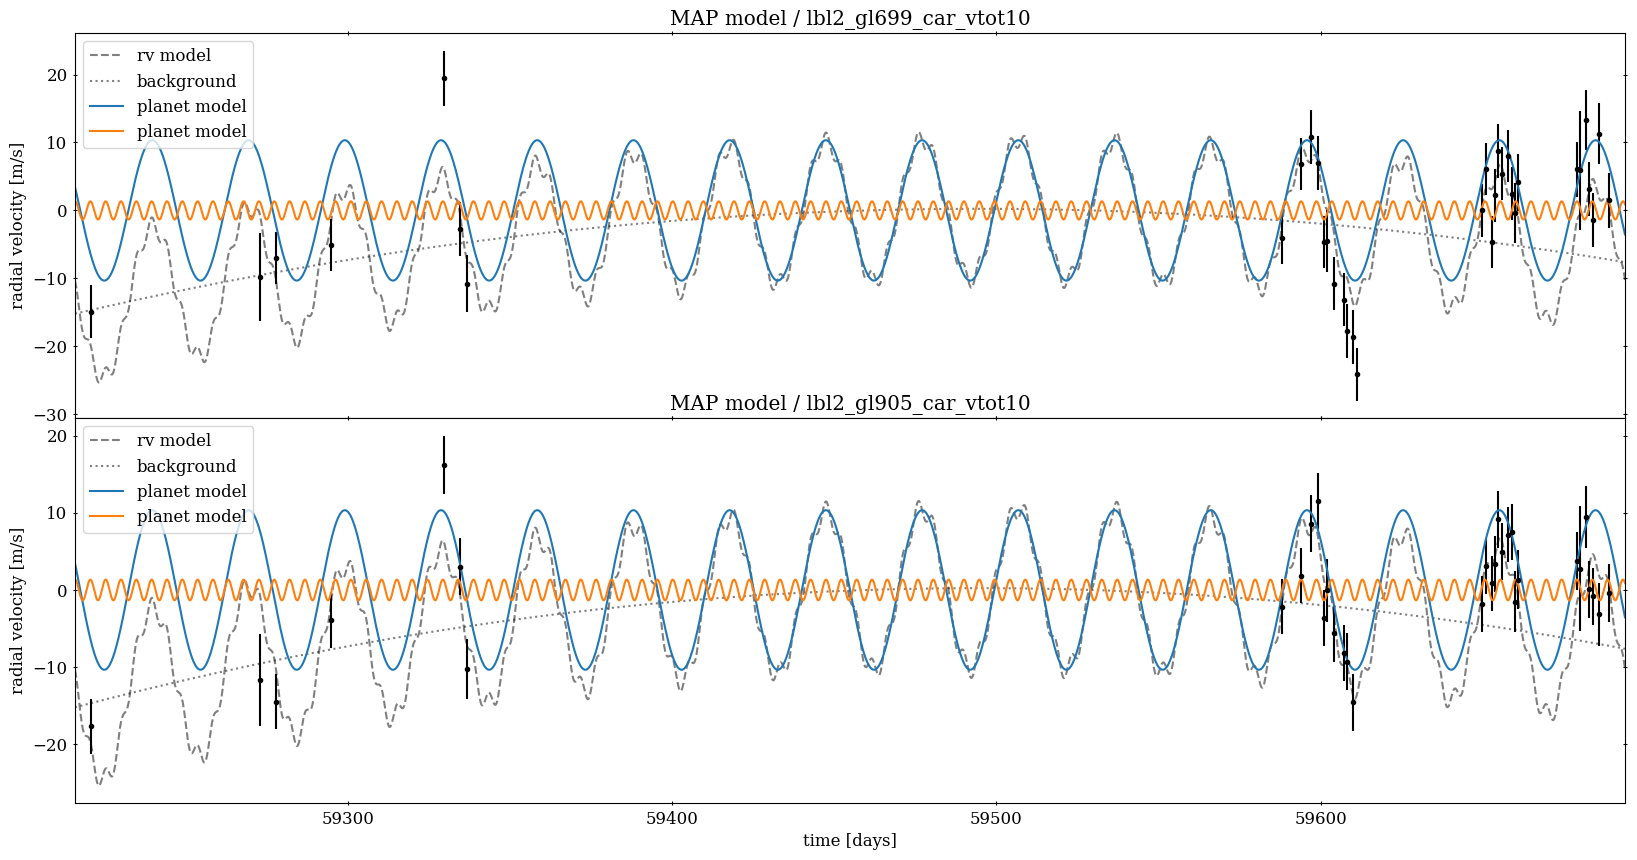

In [21]:
fig, ax = plt.subplots(len(datasets), 1, figsize=(20, 5*len(datasets)))
fig.subplots_adjust(hspace=0.0, wspace=0.0)

for k, data in enumerate(datasets):
    ax[k].errorbar(data['rjd'], data['vrad'], yerr=data['svrad'], fmt=".k")
    ax[k].plot(t[k], map_soln["rv_model_pred"], "--k", alpha=0.5, label='rv model')
    ax[k].plot(t[k], map_soln["bkg_pred"], ":k", alpha=0.5, label="background")
    ax[k].plot(t[k], map_soln["vrad_pred"], label="planet model")

    ax[k].legend(loc="upper left")
    ax[k].set_xlim(t[k].min(), t[k].max())
    ax[k].set_xlabel("time [days]")
    ax[k].set_ylabel("radial velocity [m/s]")
    _ = ax[k].set_title("MAP model"+' / '+names[k])

# Sampling

In [22]:
traces = dict()
for k, data in enumerate(datasets):
    with model[k]:
        traces[k] = pmx.sample(
            tune=2000,
            draws=2000,
            cores=2,
            chains=2,
            target_accept=0.95,
            return_inferencedata=True,
        )

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rstar, mstar, trend, logs, logK, logP, t0]


Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rstar, mstar, trend, logs, logK, logP, t0]


Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.


In [23]:
summary = dict()
for k, data in enumerate(datasets):
    summary[k] = az.summary(traces[k], stat_funcs={'median': np.median, 'std':np.std}, hdi_prob=0.997, round_to=6,
                var_names=[
                    't0', 'logP', 'P', 'K', 'logs', 'trend', 'mstar', 'rstar', 'm_pl', 'a'
                    ])
    print(summary[k].ess_bulk.mean(), summary[k].ess_tail.mean(), summary[k].r_hat.max())


4900.163401888889 2571.4617734444446 1.001841
5622.626003388889 2551.417461333333 1.00275


In [24]:
summary[0]

,mean,sd,hdi_0.15%,hdi_99.85%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,median,std
t0[0],5.924739e+04,1.056055e+00,5.924401e+04,5.925029e+04,1.478000e-02,1.045200e-02,5318.342864,2445.008640,1.000884,5.924743e+04,1.055923e+00
t0[1],5.924552e+04,3.202000e-03,5.924551e+04,5.924553e+04,4.300000e-05,3.000000e-05,5563.337806,2888.078607,0.999924,5.924552e+04,3.201000e-03
logP[0],3.388117e+00,3.065000e-03,3.379469e+00,3.398100e+00,4.300000e-05,3.000000e-05,5238.261101,2983.051102,0.999990,3.388004e+00,3.065000e-03
logP[1],1.552750e+00,9.000000e-06,1.552723e+00,1.552776e+00,0.000000e+00,0.000000e+00,5630.680701,2532.835335,0.999678,1.552750e+00,9.000000e-06
P[0],2.961030e+01,9.077700e-02,2.935517e+01,2.990721e+01,1.264000e-03,8.940000e-04,5238.261101,2983.051102,0.999991,2.960678e+01,9.076600e-02
P[1],4.724445e+00,4.300000e-05,4.724319e+00,4.724567e+00,1.000000e-06,0.000000e+00,5630.680701,2532.835335,0.999679,4.724444e+00,4.300000e-05
K[0],1.324314e+01,1.493964e+00,8.800559e+00,1.789722e+01,2.078500e-02,1.469800e-02,5157.432529,2634.666429,1.001043,1.325519e+01,1.493778e+00
K[1],1.020101e+00,8.537740e-01,3.828000e-03,4.397163e+00,1.303400e-02,9.217000e-03,2779.150590,1795.205234,1.000032,8.309560e-01,8.536670e-01
logs,9.727610e-01,5.429180e-01,-1.381762e+00,1.916770e+00,1.421300e-02,1.005200e-02,2094.130778,1535.182600,1.001841,1.094735e+00,5.428500e-01
trend[0],-1.620000e-04,5.000000e-05,-3.030000e-04,-2.100000e-05,1.000000e-06,0.000000e+00,5972.163649,3052.397287,1.000247,-1.610000e-04,5.000000e-05


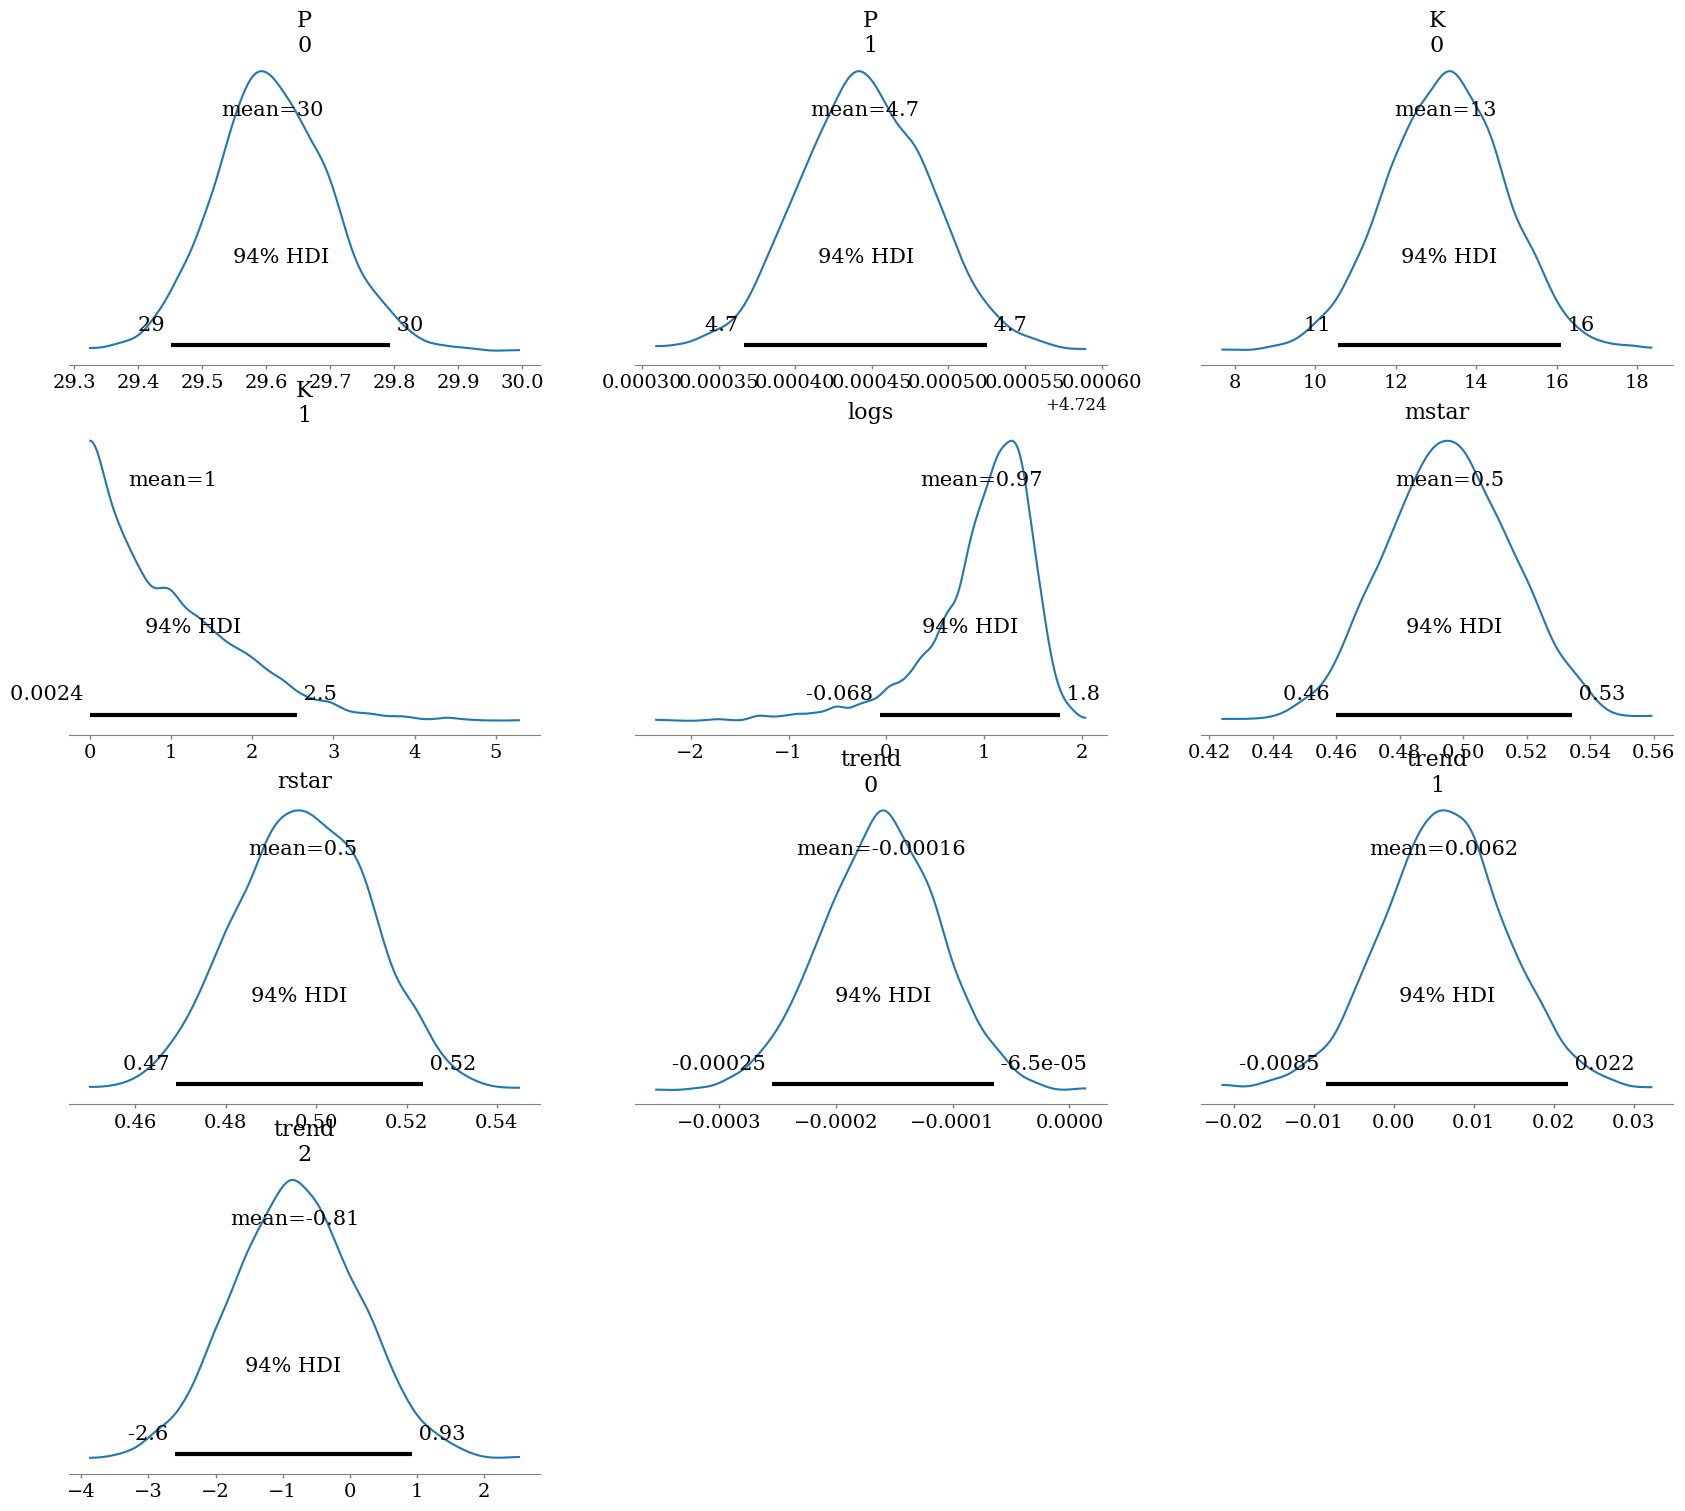

In [25]:
az.plot_posterior(traces[0], var_names=['P', 'K', 'logs', 'mstar', 'rstar', 'trend'])
plt.show()

## Results

In [26]:
mass = dict()
K = dict()
period = dict()
t_0 = dict()
m_star = dict()
r_star = dict()
smaxis = dict()
rv_jitter_ = dict()
bkg_ = dict()
vrad = dict()
vrad_pred = dict()
rv_model = dict()
rv_model_pred = dict()
rv_model_pred_ = dict()
flat_samps = dict()

for i in range(len(datasets)):
    mass[i] = [ufloat(np.median(traces[i].posterior["m_pl"].values[:, :, 0])*u.kg.to(u.M_earth), np.std(traces[i].posterior["m_pl"].values[:, :, 0])*u.kg.to(u.M_earth)),
                ufloat(np.median(traces[i].posterior["m_pl"].values[:, :, 1])*u.kg.to(u.M_earth), np.std(traces[i].posterior["m_pl"].values[:, :, 1])*u.kg.to(u.M_earth))]
    
    K[i] = [ufloat(np.median(traces[i].posterior["K"].values[:, :, 0]), np.std(traces[i].posterior["K"].values[:, :, 0])),
                ufloat(np.median(traces[i].posterior["K"].values[:, :, 1]), np.std(traces[i].posterior["K"].values[:, :, 1]))]
    
    period[i] = [ufloat(np.median(traces[i].posterior["P"].values[:, :, 0]), np.std(traces[i].posterior["P"].values[:, :, 0])),
                ufloat(np.median(traces[i].posterior["P"].values[:, :, 1]), np.std(traces[i].posterior["P"].values[:, :, 1]))]
    
    t_0[i] = [ufloat(np.median(traces[i].posterior['t0'].values[:, :, 0]), np.std(traces[i].posterior['t0'].values[:, :, 0])),
                ufloat(np.median(traces[i].posterior['t0'].values[:, :, 1]), np.std(traces[i].posterior['t0'].values[:, :, 1]))]
    
    m_star[i] = ufloat(traces[i].posterior['mstar'].median().item(), traces[i].posterior['mstar'].std().item())
    r_star[i] = ufloat(traces[i].posterior['rstar'].median().item(), traces[i].posterior['rstar'].std().item())

    smaxis[i] = [ufloat(np.median(traces[i].posterior['a'].values[:, :, 0]), np.std(traces[i].posterior['a'].values[:, :, 0])),
                ufloat(np.median(traces[i].posterior['a'].values[:, :, 1]), np.std(traces[i].posterior['a'].values[:, :, 1]))]

    logsigma_rv = ufloat(traces[i].posterior["logs"].median().item(), traces[i].posterior["logs"].std().item())
    rv_jitter_[i] = np.e**logsigma_rv
    flat_samps[i] = traces[i].posterior.stack(sample=("chain", "draw"))

    bkg_[i] = np.median(flat_samps[i]['bkg'].values, axis=-1) 
    vrad[i] = [np.median(traces[i].posterior["vrad"].values[:, :, :, 0], axis=(0, 1)), 
               np.median(traces[i].posterior["vrad"].values[:, :, :, 1], axis=(0, 1))]
    vrad_pred[i] = [traces[i].posterior["vrad_pred"].values[:, :, :, 0], traces[i].posterior["vrad_pred"].values[:, :, :, 1]]

    rv_model[i] = np.median(flat_samps[i]['rv_model'].values, axis=-1)
    rv_model_pred[i] = np.median(flat_samps[i]['rv_model_pred'].values, axis=-1)
    rv_model_pred_[i] = np.percentile(traces[i].posterior["rv_model_pred"].values,[16, 50, 84], axis=(0, 1))

    print('REDUCTION: ', names[i])
    print("Mp_b = {mb:.3f} Mearth,       Mp_c = {mc:.3f} Mearth".format(mb=mass[i][0], mc=mass[i][1]))
    print('K_b = {kb:.3f} m/s,             K_c = {kc:.3f} m/s'.format(kb=K[i][0], kc=K[i][1]))
    print("P_b = {pb:.6f} days,      P_c = {pc:.6f} days".format(pb=period[i][0], pc=period[i][1]))
    print("Epoch_b = {eb:.5f},     Epoch_c = {ec:.5f}".format(eb=t_0[i][0], ec=t_0[i][1]))
    print('a_b = {ab:.4f} AU,            a_c = {ac:.4f} AU'.format(ab=smaxis[i][0], ac=smaxis[i][1]))
    print('mstar = {m:.3f} Msun'.format(m=m_star[i]))
    print('rstar = {r:.3f} Rsun'.format(r=r_star[i]))
    print("RV jitter = ", rv_jitter_[i])
    print('---------------------------------------------')

REDUCTION:  lbl2_gl699_car_vtot10
Mp_b = 40.114+/-4.572 Mearth,       Mp_c = 1.363+/-1.403 Mearth
K_b = 13.255+/-1.494 m/s,             K_c = 0.831+/-0.854 m/s
P_b = 29.606785+/-0.090766 days,      P_c = 4.724444+/-0.000043 days
Epoch_b = 59247.43423+/-1.05592,     Epoch_c = 59245.51850+/-0.00320
a_b = 0.1482+/-0.0020 AU,            a_c = 0.0436+/-0.0006 AU
mstar = 0.496+/-0.020 Msun
rstar = 0.497+/-0.015 Rsun
RV jitter =  3.0+/-1.6
---------------------------------------------
REDUCTION:  lbl2_gl905_car_vtot10
Mp_b = 30.126+/-4.452 Mearth,       Mp_c = 1.324+/-1.239 Mearth
K_b = 9.941+/-1.441 m/s,             K_c = 0.806+/-0.752 m/s
P_b = 29.657978+/-0.098084 days,      P_c = 4.724443+/-0.000044 days
Epoch_b = 59247.20304+/-1.09290,     Epoch_c = 59245.51850+/-0.00322
a_b = 0.1484+/-0.0021 AU,            a_c = 0.0436+/-0.0006 AU
mstar = 0.495+/-0.021 Msun
rstar = 0.497+/-0.014 Rsun
RV jitter =  1.8+/-1.2
---------------------------------------------


## Plot results

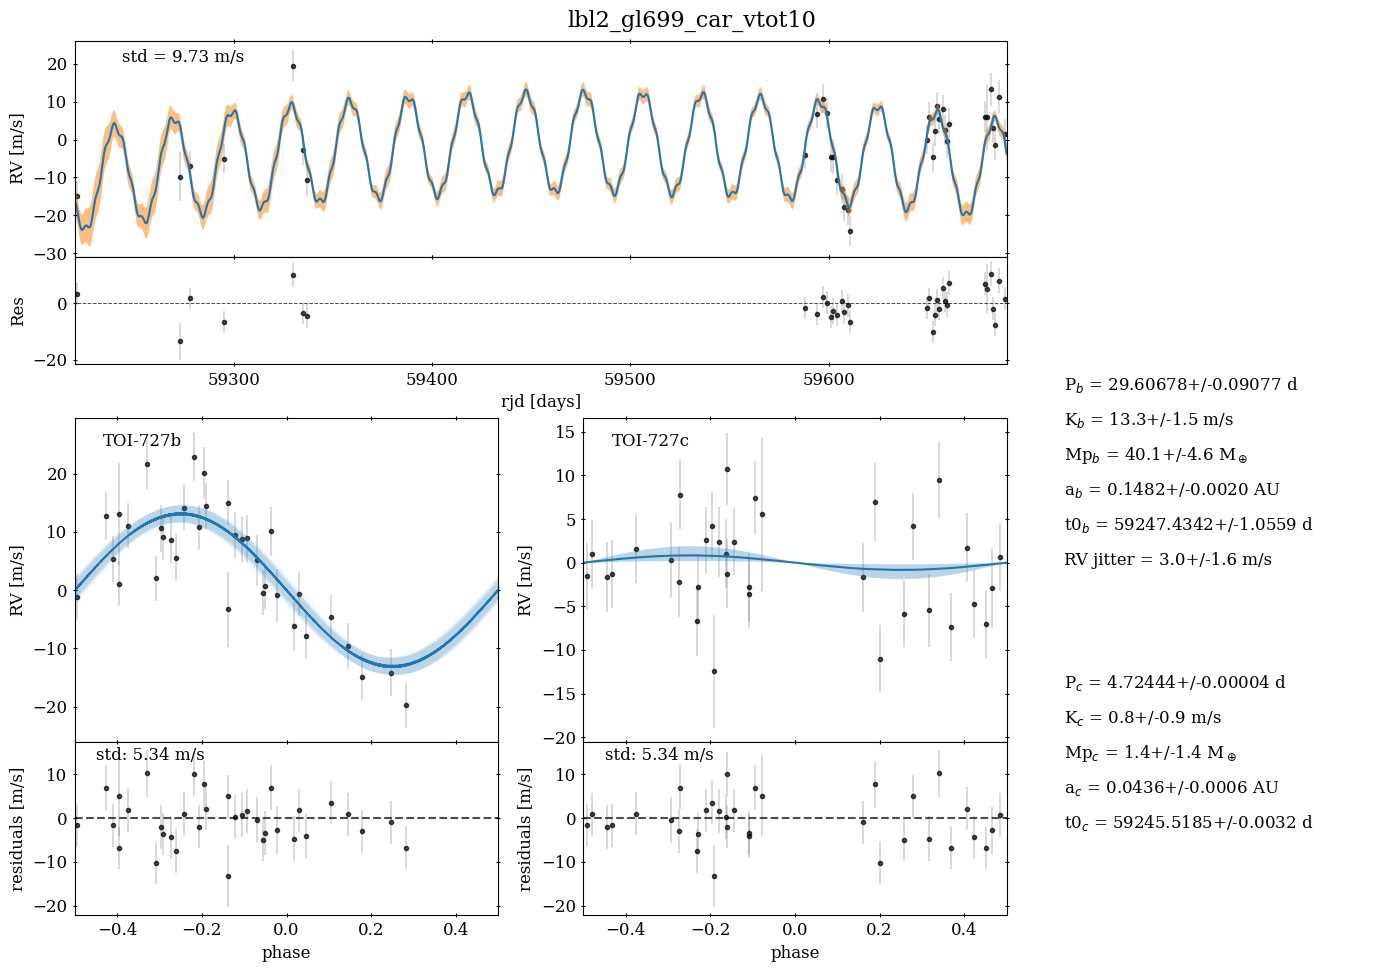

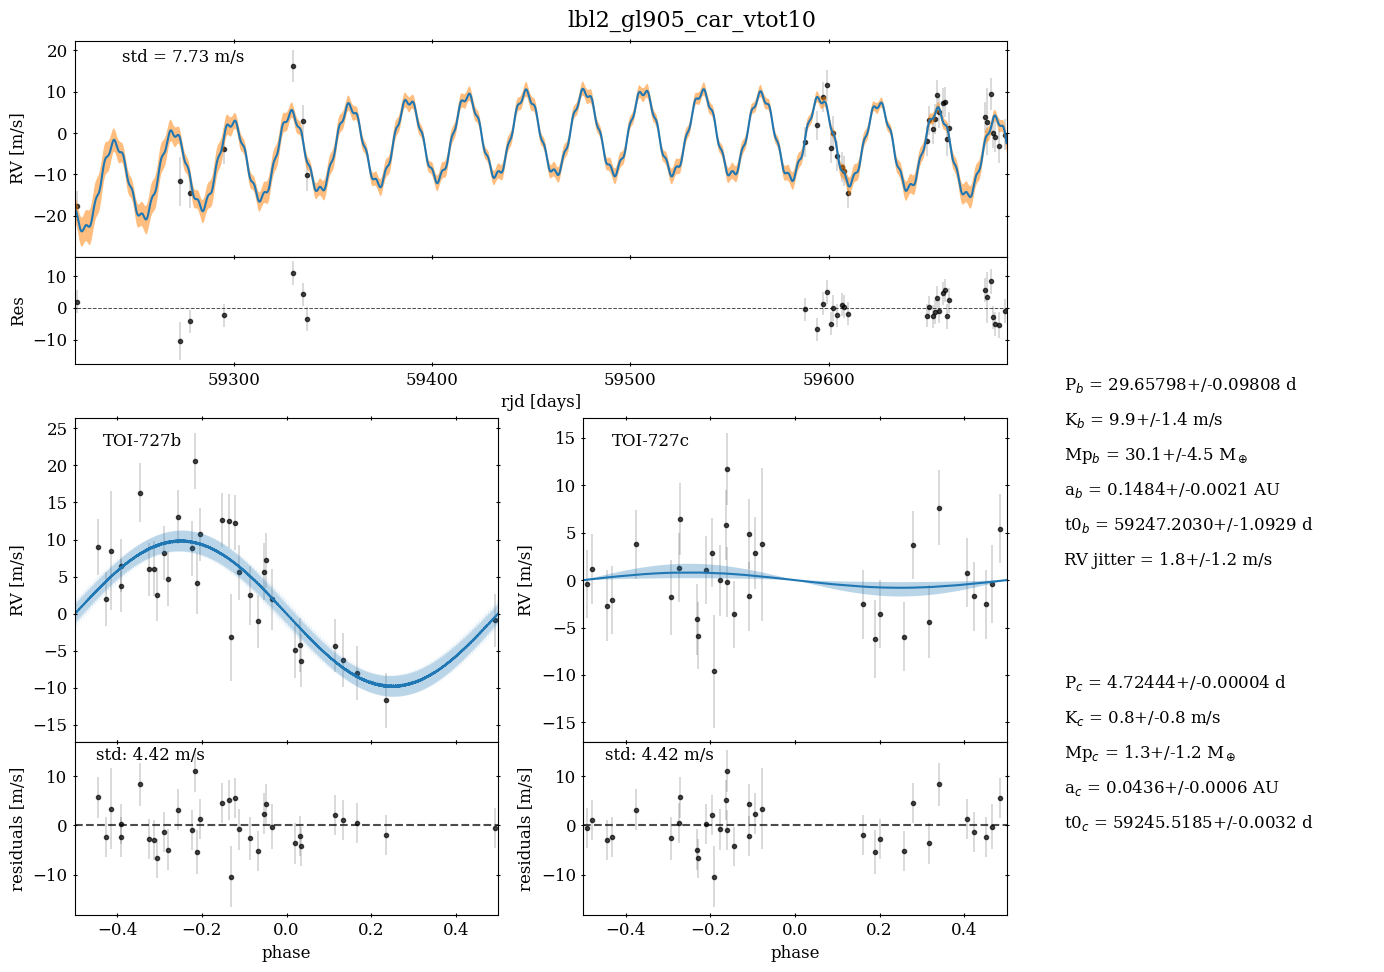

In [28]:
gs_kw = dict(width_ratios=[3, 3, 2], height_ratios=[1, 0.5, 0.25, 1.5, 0.8], hspace=0.0)

for k, data in enumerate(datasets):
    fig, ax = plt.subplot_mosaic([['0', '0', '5'],
                                  ['00', '00', '5'],
                                  ['11', '11', '5'],
                                  ['1', '2', '5'],
                                  ['3', '4', '5']],
                              gridspec_kw=gs_kw, figsize=(14, 10), layout='tight')
    fig.suptitle(names[k], y=0.97, fontsize=16)

    ax['5'].yaxis.set_visible(False)
    ax['5'].xaxis.set_visible(False)
    ax['5'].spines['left'].set_visible(False)
    ax['5'].spines['bottom'].set_visible(False)
    ax['5'].spines['top'].set_visible(False)
    ax['5'].spines['right'].set_visible(False)

    ax['5'].text(-0.10, 0.60, 'P$_b$ = {p:.5f} d'.format(p=period[k][0]), fontsize=12)
    ax['5'].text(-0.10, 0.56, 'K$_b$ = {k:.1f} m/s'.format(k=K[k][0]), fontsize=12)
    ax['5'].text(-0.10, 0.52, 'Mp$_b$ = {m:.1f} M$_\oplus$'.format(m=mass[k][0]), fontsize=12)
    ax['5'].text(-0.10, 0.48, 'a$_b$ = {a:.4f} AU'.format(a=smaxis[k][0]), fontsize=12)
    ax['5'].text(-0.10, 0.44, 't0$_b$ = {t:.4f} d'.format(t=t_0[k][0]), fontsize=12)
    ax['5'].text(-0.10, 0.40, 'RV jitter = {j:.1f} m/s'.format(j=rv_jitter_[k]), fontsize=12)

    ax['5'].text(-0.10, 0.26, 'P$_c$ = {p:.5f} d'.format(p=period[k][1]), fontsize=12)
    ax['5'].text(-0.10, 0.22, 'K$_c$ = {k:.1f} m/s'.format(k=K[k][1]), fontsize=12)
    ax['5'].text(-0.10, 0.18, 'Mp$_c$ = {m:.1f} M$_\oplus$'.format(m=mass[k][1]), fontsize=12)
    ax['5'].text(-0.10, 0.14, 'a$_c$ = {a:.4f} AU'.format(a=smaxis[k][1]), fontsize=12)
    ax['5'].text(-0.10, 0.10, 't0$_c$ = {t:.4f} d'.format(t=t_0[k][1]), fontsize=12)

    # plot the RVs and the model in the first subplot
    ax['0'].errorbar(data['rjd'], data['vrad'], yerr=data['svrad'], fmt=".k", label='rvs', markeredgecolor='k', ecolor='k', elinewidth=0.3, alpha=0.7, zorder=-10)
    ax['0'].plot(t[k], rv_model_pred_[k][1], label='model')
    art = ax['0'].fill_between(t[k], rv_model_pred_[k][0], rv_model_pred_[k][2], color="#FF7F00", alpha=0.5) 
    art.set_edgecolor("none")
    ax['0'].set_ylabel("RV [m/s]")
    ax['0'].set_xlabel("rjd [days]")
    # add initial dispersion
    ax['0'].text(0.05, 0.90, 'std = {s:.2f} m/s'.format(s=np.std(data['vrad'])), fontsize=12, transform=ax['0'].transAxes)
    ax['0'].sharex(ax['00'])
    # add the residuals in the second subplot
    ax['00'].hlines(0, data['rjd'].min(), data['rjd'].max(), ls='--', lw=0.7, alpha=0.7, color='k')
    ax['00'].errorbar(data['rjd'], data['vrad']-rv_model[k], yerr=data['svrad'], fmt=".k", 
                    label='residuals', markeredgecolor='k', ecolor='k', elinewidth=0.3, alpha=0.7, zorder=-10)
    ax['00'].set_xlim(data['rjd'].min()-1, data['rjd'].max()+1)
    ax['00'].set_xlabel("rjd [days]")
    ax['00'].set_ylabel("Res")

    # delete the third subplot so it shows as a gap
    ax['11'].set_visible(False)
    # plot the folded data in the second row
    for i, letter in enumerate('bc'):
        x_fold = (data['rjd'] - t_0[k][i].n + 0.5 * period[k][i].n) % period[k][i].n - 0.5 * period[k][i].n
        # ax[str(i+1)].errorbar(x_fold/period[k][i].n, data['vrad']-bkg_[k]-vrad[k][(i + 1) % 2], yerr=np.sqrt(data['svrad']**2+rv_jitter_[k].n**2), fmt=".k",
        #             markeredgecolor='k', ecolor='k', elinewidth=0.3, label='', alpha=0.7, zorder=-10) 
        other = np.median(traces[k].posterior["vrad"].values[:, :, :, (i + 1) % 2], axis=(0, 1))
        other += np.median(traces[k].posterior["bkg"].values, axis=(0, 1))
        ax[str(i+1)].errorbar(x_fold/period[k][i].n, data['vrad'] - other, yerr=data['svrad'], fmt=".k", 
                              markeredgecolor='k', ecolor='k', elinewidth=0.3, label='', alpha=0.7, zorder=-10)

        ax[str(i+1)].set_ylabel("RV [m/s]")
        ax[str(i+1)].set_xlabel("phase")
        ax[str(i+1)].set_xlim(-0.5, 0.5)
    
        # Compute the posterior prediction for the folded RV model for this planet
        t_fold = (t[k] - t_0[k][i].n + 0.5 * period[k][i].n) % period[k][i].n - 0.5 * period[k][i].n
        inds = np.argsort(t_fold)
        pred = np.percentile(traces[k].posterior["vrad_pred"].values[:, :, inds, i], [16, 50, 84], axis=(0, 1))
        ax[str(i+1)].plot(t_fold[inds]/period[k][i].n, pred[1], color="C0", label="TOI-727"+letter)
        art = ax[str(i+1)].fill_between(t_fold[inds]/period[k][i].n, pred[0], pred[2], color="C0", alpha=0.3)
        art.set_edgecolor("none")
        ax[str(i+1)].legend(fontsize=12, loc='upper left', frameon=False, handlelength=0)

        # Compute the residuals for both planets
        ax[str(i+3)].errorbar(x_fold/period[k][i].n, data['vrad']-other-np.median(traces[k].posterior["vrad"].values[:, :, :, i], axis=(0, 1)), yerr=np.sqrt(data['svrad']**2+rv_jitter_[k].n**2), fmt=".k",
                     markeredgecolor='k', ecolor='k', elinewidth=0.3, alpha=0.7, zorder=-10)
        ax[str(i+3)].hlines(0, -0.5, 0.5, color='k', linestyle='--', alpha=0.7)
        ax[str(i+3)].set_ylabel("residuals [m/s]")
        ax[str(i+3)].set_xlabel("phase")
        ax[str(i+3)].set_xlim(-0.5, 0.5)
        # plot inside the two plots the value of the dispersion of the residuals
        ax[str(i+3)].text(0.05, 0.90, 'std: '+str(round(np.std(data['vrad']-other-np.median(traces[k].posterior["vrad"].values[:, :, :, i], axis=(0, 1))), 2))+' m/s', transform=ax[str(i+3)].transAxes)

    #plt.savefig('fit2p_'+names[k]+'.png', dpi=300, facecolor='w', bbox_inches='tight')